In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline 
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, f1_score, confusion_matrix
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks)

import pandas as pd
import numpy as np
import math
import datetime as dt
from __future__ import division
import os

from matplotlib import pyplot as plt
%matplotlib inline
import missingno as msno

import category_encoders as ce
from sklearn import preprocessing

#library to get text similarity
import jellyfish

import pycountry
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2
    
import mpu    

import time
from datetime import date

pd.options.display.float_format = "{:.2f}".format

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
np.set_printoptions(threshold=np.nan)  

In [17]:
## LOO encoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        if self.columns:
            return X[self.columns]
        return X


class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)

    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)


class ImputeMissingConstant(BaseEstimator, TransformerMixin):
    def __init__(self, constant):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.fillna(self.constant)


class TransformToCategory(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype("category")


class TransformToFloat(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype("float64")


class DropGroupingKey(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.drop('grouping_key', axis=1)


class EncoderMixin:
    def __init__(self, cols=None):
        self.cols = cols
        self.mapping_ = {}
        self.dim_ = None

    def fit(self, X, y=None, **kwargs):
        self.dim_ = X.shape[1]

        if self.cols is None:
            self.cols = self.get_categorical_cols(X)

    def transform(self, X):
        if self.dim_ is None:
            raise ValueError("Called transform before fit")

        if X.shape[1] != self.dim_:
            raise ValueError(
                "Unexpected input dimension {X.shape[1]}, expected {self.dim_}"
            )

        if not self.cols:
            return X

    @staticmethod
    def get_categorical_cols(df):
        """Returns names of categorical columns in the DataFrame"""
        categorical_dtypes = ["object", "category"]
        return [
            col
            for col, dtype in zip(df.columns, df.dtypes)
            if dtype.name in categorical_dtypes
        ]


class MappingEncoder(EncoderMixin, BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mapping_ = {}

    def fit(self, X, y=None, **kwargs):
        super().fit(X, y, **kwargs)

        self.mapping_ = {col: self.col_map(X, y, col) for col in self.cols}

        return self

    def transform(self, X):
        super().transform(X)
        """
        Don't be tempted to put this in a dict comprehension
        When defining a function inside a loop that uses the loop variable in its body (e.g. col),
        the loop function's closure is bound to the variable, not its value.
        So all of the functions use the latest value assigned to the variable for computation.
        """
        X = X.copy()
        for col in self.cols:
            X[col] = X[col].map(self.mapping_[col])
            X[col] = X[col].fillna(self.impute_val_)

        return X

    def col_map(self, X, y, col):
        raise NotImplementedError(
            "subclasses of MappingEncoder should implement col_map"
        )

    @property
    def inv_mapping_(self):
        return {
            key: {val: key}
            for col, mapping in self.mapping_.items()
            for key, val in mapping.items()
        }


class LOOEncoder(MappingEncoder):
    def __init__(self, sigma=0.05, **kwargs):
        super().__init__(**kwargs)
        self.sigma = sigma  # Sigma of the randomly distributed noise

    def col_map(self, X, y, col):
        """Calculate the category mean per column"""
        return (
            pd.concat([X, y], axis=1)
            .groupby(col)
            .agg({y.name: "mean"})
            .to_dict()[y.name]
        )

    def fit(self, X, y, **kwargs):
        super().fit(X, y, **kwargs)
        self.impute_val_ = y.mean()
        return self

    def transform(self, X, y=None):

        if y is None:
            # Transforming test set, simple mean encoding
            return super().transform(X)

        # Transforming the train set
        cat_counts = {col: X.groupby(col).size().to_dict() for col in self.cols}
        X_new = super().transform(X)

        for col in self.cols:
            cat_count = X[col].map(cat_counts[col])
            # remove each rows part in the mean calculation and add some noise
            X_new[col] = pd.Series(((X_new[col] * cat_count) - y) / (cat_count - 1))
            X_new[col] = X_new[col].fillna(self.impute_val_) + (
                np.random.randn(X.shape[0]) * self.sigma
            )

        return X_new    

# Read data that was categorically encoded (high cardinality vars left still)

In [2]:
df=pd.read_csv('/home/gjain/df_cat_enc_part1.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
#target value counts

0    2221797
1    2197   
Name: target, dtype: int64

In [3]:
#target, timestamp, order_number, pay_id not included below
#72 cols
all_cols=['affiliate','channelcode',
       'local_trans_amt', 'trans_currency', 'nonmor', 'payment_method', 'eci',
       'card_cvvmatch', 'card_avsmatch', 'customer_title', 'website_language',
       'brand_continent', 'HasTicketInsurance', 'HasInsurance', 'HasBaggage',
       'HasBaggage_Sale', 'HasAirhelpPlus', 'UsedVoucher', 'HasSP', 'gender',
       'BookerCity', 'BookerCountry_Name', 'TotalAmountEUR', 'airline',
       'Consolidator', 'OriginAirportCode', 'OriginCityName',
       'OriginCountryName', 'OriginWorldPartName', 'OriginRegion',
       'OriginSubRegion', 'DestinationAirportCode', 'DestinationCityName',
       'DestinationCountryName', 'DestinationWorldPartName',
       'DestinationRegion', 'DestinationSubRegion', 'Supplier',
       'DomesticOrInternational', 'Haul', 'OneWayOrReturn', 'IsCombinedOneWay',
       'IsITFare', 'TotalNumberOfPassengers', 'TotalNumberOfAdults',
       'TotalNumberOfChildren', 'TotalNumberOfInfants', 'COW_NumberOfSegments',
       'COW_NumberOfInboundSegments', 'COW_NumberOfOutboundSegments',
       'NumberOfTickets', 'FareBaseAmount', 'HasSplitPnr', 'DeviceType',
       'OrderDateBrandTime_Month', 'IsLowCost', 'email_user_id_len',
       'email_domain', 'dob_month', 'bookerIsTravelAgency',
       'successful_attempt_no', 'country_ip_flight_MatchScore',
       'flight_distance', 'days_to_departure', 'vacation_length',
       'cities_in_itinerary', 'cabin_class', 'name_len', 'weekend_booking',
       'booking_daytime', 'bookerAgeBracket', 'email_sanity_score']

loo_cols=['affiliate','channelcode','trans_currency','payment_method','eci','website_language','BookerCity',
          'BookerCountry_Name','airline',
          'Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName',
          'DestinationWorldPartName','DestinationSubRegion','email_domain']   

all_cat_cols=['affiliate','channelcode','trans_currency','nonmor','payment_method','eci','card_cvvmatch','card_avsmatch','customer_title','website_language',
          'brand_continent','HasTicketInsurance','HasInsurance','HasBaggage','HasBaggage_Sale','HasAirhelpPlus','UsedVoucher','HasSP','gender',
          'BookerCity','BookerCountry_Name','airline','Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName','OriginRegion',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName','DestinationWorldPartName','DestinationRegion','DestinationSubRegion',
          'Supplier','DomesticOrInternational','Haul','OneWayOrReturn','IsCombinedOneWay','IsITFare',
          'HasSplitPnr','DeviceType','IsLowCost','email_domain','cabin_class','bookerIsTravelAgency','weekend_booking','OrderDateBrandTime_Month','dob_month','booking_daytime',
         'bookerAgeBracket']

#Get location of loo_cols, our categorical columns, in df[all_cols], to feed in Pool
df2=df[all_cols]
categorical_features_pos=[df2.columns.get_loc(c) for c in loo_cols]
categorical_features_pos

[0, 1, 3, 5, 6, 10, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 57]

# EDA

## Performing Pearson correlation analysis between attributes to aid in feature selection

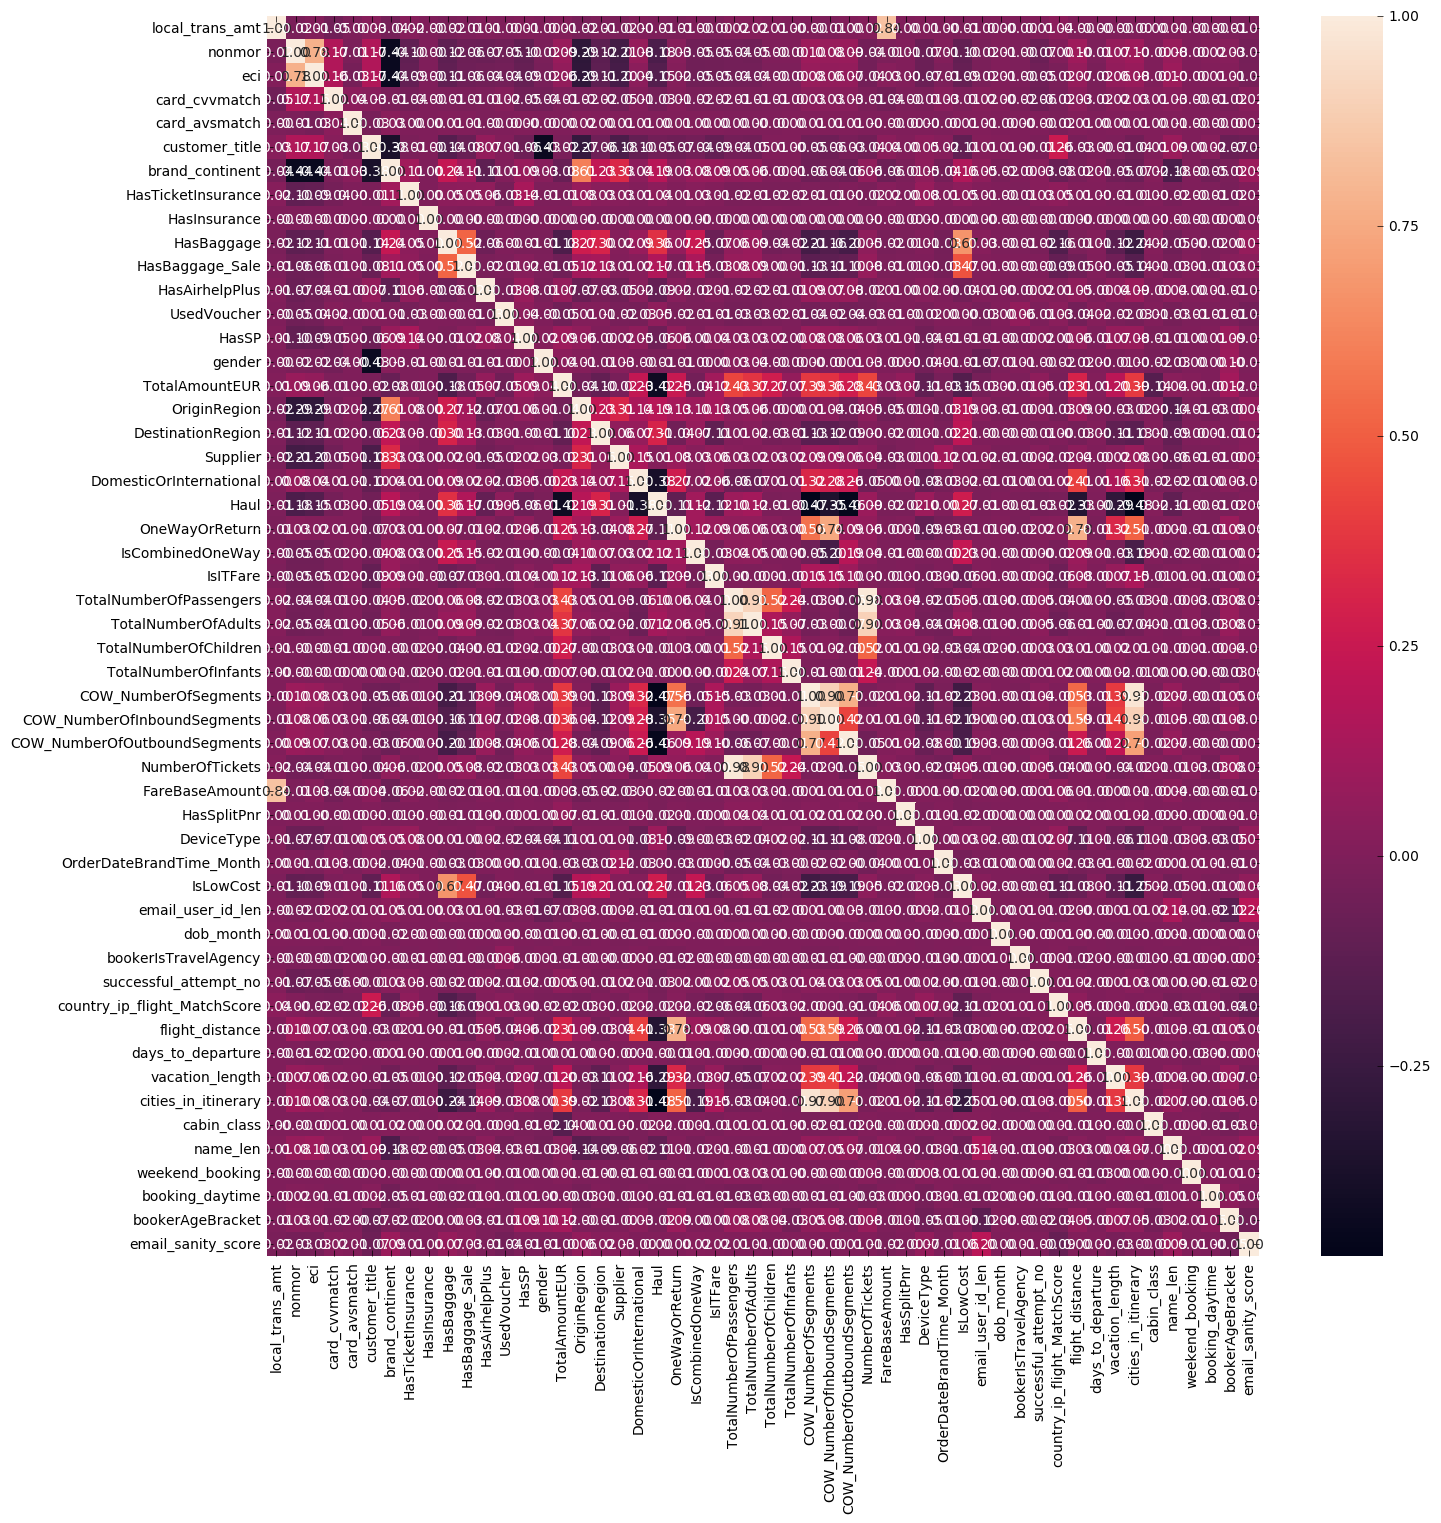

In [18]:
import seaborn as sns

plt.figure(figsize=(16,16))
sns.heatmap(df[all_cols].corr(), annot=True, fmt=".2f")

plt.show()

In [43]:
corr_mat=df[all_cols].corr()

for col in corr_mat.columns:
    print(corr_mat[col][(corr_mat[col]>0.75) & (corr_mat[col]<1)])
    print("\n")

FareBaseAmount   0.84
Name: local_trans_amt, dtype: float64


eci   0.78
Name: nonmor, dtype: float64


nonmor   0.78
Name: eci, dtype: float64


Series([], Name: card_cvvmatch, dtype: float64)


Series([], Name: card_avsmatch, dtype: float64)


Series([], Name: customer_title, dtype: float64)


Series([], Name: brand_continent, dtype: float64)


Series([], Name: HasTicketInsurance, dtype: float64)


Series([], Name: HasInsurance, dtype: float64)


Series([], Name: HasBaggage, dtype: float64)


Series([], Name: HasBaggage_Sale, dtype: float64)


Series([], Name: HasAirhelpPlus, dtype: float64)


Series([], Name: UsedVoucher, dtype: float64)


Series([], Name: HasSP, dtype: float64)


Series([], Name: gender, dtype: float64)


Series([], Name: TotalAmountEUR, dtype: float64)


Series([], Name: OriginRegion, dtype: float64)


Series([], Name: DestinationRegion, dtype: float64)


Series([], Name: Supplier, dtype: float64)


Series([], Name: DomesticOrInternational, dtype: float64)


Serie

In [45]:
# # Dropping 1 of highly correlated pairs
# corr_cols_to_drop=['local_trans_amt','eci','flight_distance','TotalNumberOfPassengers','NumberOfTickets','cities_in_itinerary',
#                    'COW_NumberOfInboundSegments','COW_NumberOfOutboundSegments','']

# all_cols=list(set(all_cols)-set(corr_cols_to_drop))
# loo_cols=list(set(loo_cols)-set(corr_cols_to_drop))
# df2=df[all_cols]
# categorical_features_pos=[df2.columns.get_loc(c) for c in loo_cols]
# categorical_features_pos

[47, 12, 39, 14, 5, 23, 7, 42, 52, 34, 25, 61, 27, 28, 37, 8, 17, 9, 44, 31]

## Feature variance check (aim is to check for categorical features)

/root/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


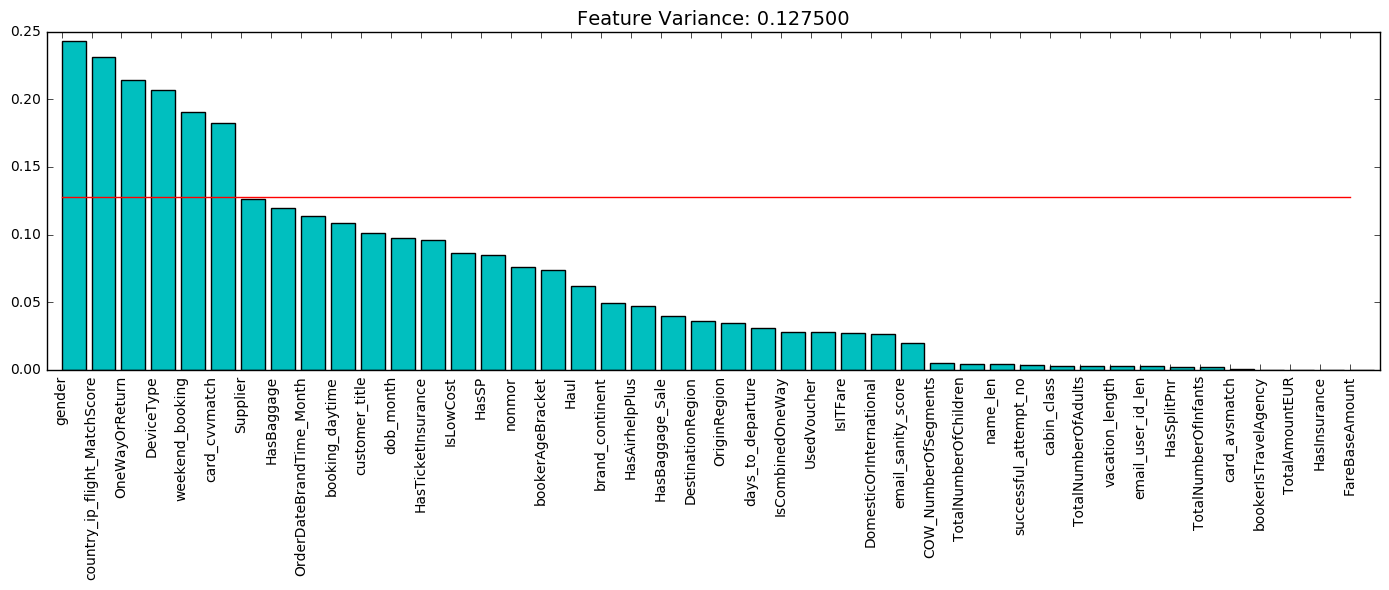

In [58]:
#Normalise the dataset. This is required for getting the variance threshold
scaler = MinMaxScaler()
scaler.fit(df2[set(all_cols)-set(loo_cols)])
scaled_variance_one_hot = scaler.transform(df2[set(all_cols)-set(loo_cols)])

#Set the threshold values and run VarianceThreshold 
thres=.85* (1 - .85) #this threshold means that up to 85% samples can have the same value
sel = VarianceThreshold(threshold=thres)
sel.fit(scaled_variance_one_hot)
variance = sel.variances_

#Sorting of the score in acsending orders for plotting
indices = np.argsort(variance)[::-1]
feature_list = list(df2[set(all_cols)-set(loo_cols)].columns)
sorted_feature_list = []
thres_list = []
for f in range(len(df2[set(all_cols)-set(loo_cols)].columns)):
    sorted_feature_list.append(feature_list[indices[f]])
    thres_list.append(thres)
    
plt.figure(figsize=(14,6))
plt.title("Feature Variance: %f" %(thres), fontsize = 14)
plt.bar(range(len(df2[set(all_cols)-set(loo_cols)].columns)), variance[indices], color="c")
plt.xticks(range(len(df2[set(all_cols)-set(loo_cols)].columns)), sorted_feature_list, rotation = 90)
plt.xlim([-0.5, len(df2[set(all_cols)-set(loo_cols)].columns)])
plt.plot(range(len(df2[set(all_cols)-set(loo_cols)].columns)), thres_list, "k-", color="r")
plt.tight_layout()
plt.show()    

In [64]:
# #Let us drop insurance feature
# # Dropping 1 of highly correlated pairs
# corr_cols_to_drop=['HasInsurance']

# all_cols=list(set(all_cols)-set(corr_cols_to_drop))
# loo_cols=list(set(loo_cols)-set(corr_cols_to_drop))
# df2=df[all_cols]
# categorical_features_pos=[df2.columns.get_loc(c) for c in loo_cols]
# categorical_features_pos

[47, 12, 14, 52, 34, 17, 37, 39, 5, 23, 7, 42, 8, 25, 60, 27, 28, 9, 44, 30]

## Create Pool object for training data. Data can only be passed to catboost in this way

In [22]:
# #Reading data
# train_data = Pool(
#     data=df2.values,
#     label=df.target.values,
#     cat_features=categorical_features_pos,
#     has_header=True,
#     thread_count=-1
# )

# print(train_data.shape)
# print(train_data.is_empty_)

# #Since cat_features is already defined here, it will not be used in the fit method

## Train test split code snippet

In [ ]:
### Train-test split
# from sklearn.model_selection import train_test_split

# #Split data_for_sample into Train(70%) and Test(30%) 
# X_train, X_test, Y_train, Y_test = train_test_split(features, target, train_size=0.7,random_state = 12)

# print(features.shape)
# print('X_train:',X_train.shape)
# print('X_test:',X_test.shape)
# print('Y_train:',Y_train.shape)
# print('Y_test:',Y_test.shape)

# Hyperparameter tuning using GridSearchCV

## Class weights for handling class imbalance

In [15]:
# from sklearn.utils import class_weight

# # class_weights={0: 1., 1: 50.}
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(df.target),
#                                                  df.target)
# class_weights

array([  5.00494420e-01,   5.06143377e+02])

In [65]:
#rsm: Random subspace method. The percentage of features to use at each split selection, when features are selected over again at random.
seed=26
train_dir='/home/gjain/'

start_time = time.time()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#`````````````````````````````````````````````````````````````````````````````````````````````````

#Define estimator
cb_clf=CatBoostClassifier(cat_features=categorical_features_pos, 
#                           class_weights=class_weights,
                          loss_function='Logloss', nan_mode='Min', random_seed=seed, 
                       one_hot_max_size=3, train_dir=train_dir, 
                       custom_loss=['AUC', 'F1','Kappa'], 
                      od_type='Iter')

#Set up pipeline
steps = [("model", cb_clf)]
pipe = Pipeline(steps)

tune_params =   {'model__n_estimators':[650],
                 'model__learning_rate':[0.1],
                 'model__depth':[10],
                 'model__l2_leaf_reg':[5],
                 'model__size_reg':[0.5],
                 'model__rsm':[0.6], 
                 'model__class_weights':[[0.5,400]]
                 }

fit_parameters={'model__plot':True,
                'model__early_stopping_rounds':5,
                'model__metric_period': 100}
                #metric period is to control verbosity of catboost

model=RandomizedSearchCV(pipe, param_distributions=tune_params,scoring='f1', 
                         n_iter=10, 
#                          n_jobs=-1,
                         refit=True, cv=5, verbose=10,return_train_score=True)
#n_iter in randomisedsearchcv is number of param combos to try

# model=GridSearchCV(pipe, param_grid=tune_params,scoring='f1', refit=True, 
#                       cv=5, verbose=0,return_train_score=True)

model=model.fit(df2,df.target,**fit_parameters)

best_params=model.best_params_ 

# best_est=model.best_estimator_

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#`````````````````````````````````````````````````````````````````````````````````````````````````

print ('Best params for the model are:')
print (model.best_params_)
print('Best score:')
print(model.best_score_)
print ('-------------------------------')

pd.DataFrame(model.cv_results_).to_csv('cv_results.csv')

end_time = time.time()
time_taken = end_time - start_time # time_taken is in seconds
minutes, seconds = divmod(time_taken, 60)

/root/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] model__l2_leaf_reg=5, model__depth=9, model__size_reg=0.5, model__rsm=0.6, model__class_weights=[0.5, 400], model__n_estimators=650, model__learning_rate=0.1 


0:	learn: 0.5652181	total: 7.53s	remaining: 1h 21m 29s
100:	learn: 0.0555951	total: 9m 48s	remaining: 53m 21s
200:	learn: 0.0790684	total: 19m 57s	remaining: 44m 34s


Training has stopped (degenerate solution on iteration 231, probably too small l2-regularization, try to increase it)


[CV]  model__l2_leaf_reg=5, model__depth=9, model__size_reg=0.5, model__rsm=0.6, model__class_weights=[0.5, 400], model__n_estimators=650, model__learning_rate=0.1, score=0.220431840154689, total=24.7min
[CV] model__l2_leaf_reg=5, model__depth=9, model__size_reg=0.5, model__rsm=0.6, model__class_weights=[0.5, 400], model__n_estimators=650, model__learning_rate=0.1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.5min remaining:    0.0s


0:	learn: 0.5763503	total: 6.61s	remaining: 1h 11m 28s


KeyboardInterrupt: 

In [17]:
model.cv_results_

{'mean_fit_time': array([ 3110.43772554]),
 'mean_score_time': array([ 14.19854527]),
 'mean_test_score': array([ 0.50853075]),
 'mean_train_score': array([ 0.66994898]),
 'param_model__class_weights': masked_array(data = [[0.5, 400]],
              mask = [False],
        fill_value = ?),
 'param_model__depth': masked_array(data = [9],
              mask = [False],
        fill_value = ?),
 'param_model__l2_leaf_reg': masked_array(data = [5],
              mask = [False],
        fill_value = ?),
 'param_model__learning_rate': masked_array(data = [0.1],
              mask = [False],
        fill_value = ?),
 'param_model__n_estimators': masked_array(data = [650],
              mask = [False],
        fill_value = ?),
 'param_model__rsm': masked_array(data = [0.6],
              mask = [False],
        fill_value = ?),
 'param_model__size_reg': masked_array(data = [0.5],
              mask = [False],
        fill_value = ?),
 'params': [{'model__class_weights': [0.5, 400],
   'model__d

# Catboost self-tuning - enables tracking train-test scores together for overfitting 
1. use best model = True and let model pick the number of trees
2. l2 leaf reg
3. random strength
4. reduce learning rate

### Stratified K Fold used for train-test splitting

In [5]:
skf = StratifiedKFold(n_splits=5, random_state=34, shuffle=True)

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = df2[train_index], df2[test_index]
#     y_train, y_test = df.target[train_index], df.target[test_index]
   

# Only take the first fold.
train_index, test_index = next(iter(skf.split(df2, df.target)))   

X_train = df2.iloc[train_index,:]
y_train = df.target[train_index]
X_test = df2.iloc[test_index,:]
y_test = df.target[test_index]

print (X_train.shape)
print (X_test.shape)

(1779194, 72)
(444800, 72)


In [6]:
y_test.value_counts()
# THIS IS NOT BALANCED CORRECTLY. CLASS WEIGHTS ARE NOT GOING TO WORK PROPERLY

0    444360
1    440   
Name: target, dtype: int64

In [11]:
#loss function: for optimization
#custom loss: to print during training
#eval metric: The metric used for overfitting detection (if enabled) and best model selection (if enabled).

#sklearn.metrics f1 score: only for positive class in binary classification (else average)
#catboost f1: always average of 2 classes

seed=26
train_dir='/home/gjain/'

clf = CatBoostClassifier(iterations=1000,
                        learning_rate=0.1,
                        loss_function = 'Logloss',
                        depth=10,
                        l2_leaf_reg = 5, #try 10
                        custom_loss= ['F1','AUC'],
                        eval_metric = 'Logloss',                        
                        use_best_model=True,
                        nan_mode='Min', 
                        random_seed=seed,  
                        one_hot_max_size=3,
                        cat_features=categorical_features_pos,
                        train_dir=train_dir, 
                        od_type='Iter',
                        rsm=0.6,
                        class_weights=[0.5,400])

clf=clf.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test), early_stopping_rounds=50, metric_period=100)

0:	learn: 0.5672992	test: 0.5664039	best: 0.5664039 (0)	total: 4.6s	remaining: 1h 16m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1769120046
bestIteration = 20

Shrink model to first 21 iterations.


In [107]:
clf.get_evals_result()

{'learn': {'F1': [0.9008422875388489], 'Logloss': [0.566095906950848]},
 'validation_0': {'AUC': [0.9510273253054444],
  'F1': [0.8965460905803904,
   0.899225746982956,
   0.9039872912728135,
   0.9069768790484861,
   0.9131733931327048,
   0.9185241457898099,
   0.9162888565912493,
   0.9203602239042178,
   0.9193605581004899,
   0.9226780209250194,
   0.9208233618439603,
   0.9208193672837275,
   0.9191013811180949,
   0.9164136861603753,
   0.9181116802261405,
   0.9181201373081456,
   0.9223355520951757,
   0.9236178531132744,
   0.9235801558541513,
   0.9233271253573958,
   0.9236003504316986,
   0.9246454700814888,
   0.9257132556672316,
   0.9255289307728196,
   0.9263043974730276,
   0.9268059107163389,
   0.9268234465373655,
   0.925326880190907,
   0.9235412180078817,
   0.9214775375158305,
   0.9216887830827786,
   0.9217849589738087,
   0.9219150315364908,
   0.9221888458083194,
   0.9226066580074226,
   0.9241432422025414,
   0.9228890311283761,
   0.9244815596215624,
   

## Feature importances

In [ ]:
clf = CatBoostClassifier(iterations=650,
                        learning_rate=0.1,
                        loss_function = 'Logloss',
                        depth=10,
                        l2_leaf_reg = 5, #try 10
#                         custom_loss= ['F1','AUC'],
#                         eval_metric = 'F1',                        
#                         use_best_model=True,
                        nan_mode='Min', 
                        random_seed=seed,  
                        one_hot_max_size=3,
                        cat_features=categorical_features_pos,
                        train_dir=train_dir, 
                        od_type='Iter',
                        rsm=0.6,
                        class_weights=[0.5,400])

clf=clf.fit(df2, df.target, early_stopping_rounds=50, metric_period=100)

In [ ]:
train_data = Pool(
    data=df2.values,
    label=df.target.values,
    cat_features=categorical_features_pos,
    has_header=True,
    thread_count=-1
)

imp=clf.get_feature_importance(train_data)

feature_score=pd.DataFrame()
feature_score['Feature']=df2.columns
feature_score['Score']=imp
feature_score.head()

In [ ]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

# ClusterCentroids under sampling + class weights trial
use cluster centroids to halve class 0 and then use class weights

In [13]:
df.target.value_counts()

0    2221797
1    2197   
Name: target, dtype: int64

In [27]:
#Label Encoding LOO cols for running ClusterCentroids as it needs numeric columns
try_dict={col: {cat: n for n, cat in enumerate(df[col].astype('category').cat.categories)} 
               for col in loo_cols}

try_dict_reverse={col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
               for col in loo_cols}

# df.replace(try_dict,inplace=True) 

for col in loo_cols:
#   df[col].map(try_dict).fillna(df['col1'])
  df[col]=df[col].map(try_dict[col])
    
df.head()

,timestamp,order_number,pay_id,affiliate,channelcode,local_trans_amt,trans_currency,nonmor,payment_method,eci,card_cvvmatch,card_avsmatch,customer_title,website_language,brand_continent,HasTicketInsurance,HasInsurance,HasBaggage,HasBaggage_Sale,HasAirhelpPlus,UsedVoucher,HasSP,gender,BookerCity,BookerCountry_Name,TotalAmountEUR,airline,Consolidator,OriginAirportCode,OriginCityName,OriginCountryName,OriginWorldPartName,OriginRegion,OriginSubRegion,DestinationAirportCode,DestinationCityName,DestinationCountryName,DestinationWorldPartName,DestinationRegion,DestinationSubRegion,Supplier,DomesticOrInternational,Haul,OneWayOrReturn,IsCombinedOneWay,IsITFare,TotalNumberOfPassengers,TotalNumberOfAdults,TotalNumberOfChildren,TotalNumberOfInfants,COW_NumberOfSegments,COW_NumberOfInboundSegments,COW_NumberOfOutboundSegments,NumberOfTickets,FareBaseAmount,HasSplitPnr,DeviceType,OrderDateBrandTime_Month,IsLowCost,email_user_id_len,email_domain,dob_month,bookerIsTravelAgency,successful_attempt_no,country_ip_flight_MatchScore,flight_distance,days_to_departure,vacation_length,cities_in_itinerary,cabin_class,name_len,weekend_booking,booking_daytime,bookerAgeBracket,email_sanity_score,target
0,2018-06-05 00:38:27 UTC,CHNL-11348593,4093147735,33,1,759.31,8,0,7,3,2,2,7,9,3,0,0,0,0,0,0,0,0,114812,550,759.31,184,66,1299,1197,36,0,0,9,314,1402,67,4,3,22,5,1,0,1,0,0,1,1,0,0,2,1,1,1,749.81,0,1,6,0,7,57325,8.00,0,1,0,9999.00,16,88,3,1,22,0,1,2,0.00,0
1,2018-11-07 15:43:09 UTC,VUS-8712542,4326174179,42,1,879.78,26,0,21,5,2,2,5,2,1,0,0,0,0,0,0,0,1,112287,817,770.89,325,66,1299,1197,36,0,0,9,811,2005,212,6,1,11,5,1,0,0,0,0,1,1,0,0,2,0,2,1,879.78,0,1,11,0,6,57325,2.00,0,1,0,9375.21,27,0,3,1,15,0,3,4,0.46,0
2,2018-11-27 13:47:52 UTC,FL-15578084,4360626058,6,462,615.00,8,0,23,3,2,2,2,1,3,0,0,0,0,0,0,0,1,16880,190,-47.63,124,66,1299,1197,36,0,0,9,1014,891,189,0,0,10,1,1,1,1,0,0,1,1,0,0,2,1,1,1,0.00,0,0,11,0,8,132922,1.00,0,1,0,9999.00,10,2,3,1,13,0,2,4,0.75,0
3,2018-09-24 08:36:41 UTC,KUSW-5029188,0000000000F8CE732C78,36,310,830.52,26,0,26,4,2,2,5,2,1,0,0,0,0,0,0,0,1,29266,817,707.09,253,66,1299,1197,36,0,0,9,1350,1250,103,0,0,4,1,1,1,1,0,0,1,1,0,0,2,1,1,1,830.52,0,0,9,0,12,2293,12.00,0,1,0,9999.00,2,7,3,1,22,0,1,2,1.35,0
4,2018-11-29 22:33:36 UTC,BBE-1112497,4365153953,4,531,835.99,8,0,3,3,2,2,7,4,3,0,0,0,0,0,0,1,0,88881,70,835.99,124,66,1299,1197,36,0,0,9,251,262,17,4,3,22,1,1,0,1,0,0,1,1,0,0,4,2,2,1,826.00,0,0,11,0,8,58976,2.00,0,1,0,9999.00,20,19,5,1,17,0,1,3,0.66,0


In [33]:
sampler = RandomUnderSampler({1: 2197, 0: 50000})
X_sample, y_sample = sampler.fit_sample(df[all_cols], df.target)

In [ ]:
#convert loo encols that were label encoded BACK
#use the latest df in the code below

In [15]:
#rsm: Random subspace method. The percentage of features to use at each split selection, when features are selected over again at random.
seed=26
train_dir='/home/gjain/'

start_time = time.time()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#`````````````````````````````````````````````````````````````````````````````````````````````````

#Define estimator
cb_clf=CatBoostClassifier(cat_features=categorical_features_pos, 
#                           class_weights=class_weights,
                          loss_function='Logloss', nan_mode='Min', random_seed=seed, 
                       one_hot_max_size=3, train_dir=train_dir, 
                       custom_loss=['AUC', 'F1','Kappa'], 
                      od_type='Iter')

#Set up pipeline (Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. 
#The final estimator only needs to implement fit.)
steps = [("model", cb_clf)]
pipe = Pipeline(steps)

tune_params =   {'model__n_estimators':[650],
                 'model__learning_rate':[0.01],
                 'model__depth':[3,5,7],
                 'model__l2_leaf_reg':[3,1,5,10],
                 'model__size_reg':[0.5],
                 'model__rsm':[0.4,0.6], 
                 'model__class_weights':[[1,22],[1,20],[1,18]]
                 }

fit_parameters={'model__plot':True,
                'model__early_stopping_rounds':5,
                'model__metric_period': 100}
                #metric period is to control verbosity of catboost

model=RandomizedSearchCV(pipe, param_distributions=tune_params,scoring='f1', 
                         n_iter=10, 
#                          n_jobs=-1,
                         refit=True, cv=5, verbose=10,return_train_score=True)
#n_iter in randomisedsearchcv is number of param combos to try

# model=GridSearchCV(pipe, param_grid=tune_params,scoring='f1', refit=True, 
#                       cv=5, verbose=0,return_train_score=True)

model=model.fit(df2,df.target,**fit_parameters)

best_params=model.best_params_ 

# best_est=model.best_estimator_

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#`````````````````````````````````````````````````````````````````````````````````````````````````
print ('Best params for the model are:')
print (model.best_params_)
print('Best score:')
print(model.best_score_)
print ('-------------------------------')

# pd.DataFrame(model.cv_results_).to_csv('cv_results.csv')

end_time = time.time()
time_taken = end_time - start_time # time_taken is in seconds
minutes, seconds = divmod(time_taken, 60)

TypeError: All intermediate steps should be transformers and implement fit and transform. 'ClusterCentroids(estimator=None, n_jobs=1, random_state=None, ratio=None,
         sampling_strategy={0: 1000000, 1: 2197}, voting='auto')' (type <class 'imblearn.under_sampling._prototype_generation._cluster_centroids.ClusterCentroids'>) doesn't

# Run for trees>650

In [ ]:
# Export the model JSON
model.save_model("model_json", format = "json", export_parameters=None)

from_file = CatBoostClassifier()
# Load the model from JSON
from_file.load_model("model_json", format = 'json')

# Threshold tuning with Precion-Recall curves

# Confusion matrix and precision recall examples

# Get ROC curve

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

# Model Comparison

In [ ]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [ ]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

# Feature importances

In [ ]:
model.get_feature_importance(prettified=True)

# Out of time validation for November